LL restr.:   -476.040  rhobar: 0.140  Parameters: 6
LL unrestr.: -472.624  rhobar: 0.144  Parameters: 7
Likelihood ratio: 6.831
Output files:
boxcox_restricted~06.html
boxcox_unrestricted~06.html


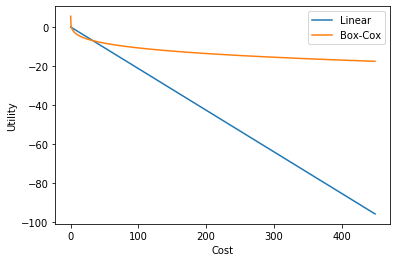

In [35]:
# Translated to .py by Monique A. Stinson
# 31.12.2016
# Adpated to PandasBiogeme by Michel Bierlaire
# Thu Oct 25 13:44:49 2018

import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.models import boxcox
from biogeme.expressions import Beta, DefineVariable, log
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("telephone.dat",'\t')
database = db.Database("telephone",df)
pd.options.display.float_format = '{:.3g}'.format
globals().update(database.variables)

#Parameters to be estimated
# Arguments:
#   1  Name for report. Typically, the same as the variable
#   2  Starting value
#   3  Lower bound
#   4  Upper bound
#   5  0: estimate the parameter, 1: keep it fixed
ASC_BM	 = Beta('ASC_BM',0,None,None,0)
ASC_SM	 = Beta('ASC_SM',0,None,None,1)
ASC_LF	 = Beta('ASC_LF',0,None,None,0)
ASC_EF	 = Beta('ASC_EF',0,None,None,0)
ASC_MF	 = Beta('ASC_MF',0,None,None,0)
B_FCOST	 = Beta('B_FCOST',0,None,None,0)
B_MCOST  = Beta('B_MCOST',0,None,None,0)
LAMBDA   = Beta('LAMBDA',0.00003,None,None,0)

# Define here arithmetic expressions for name that are not directly
# available from the data

#Utilities restricted model 
M1_V_BM = ASC_BM + B_MCOST * cost1
M1_V_SM = ASC_SM + B_MCOST * cost2
M1_V_LF = ASC_LF + B_FCOST * cost3
M1_V_EF = ASC_EF + B_FCOST * cost4
M1_V_MF = ASC_MF + B_FCOST * cost5
M1_V = {1: M1_V_BM, 2: M1_V_SM, 3: M1_V_LF, 4: M1_V_EF, 5: M1_V_MF}

# The choice model is a logit, with availability conditions
avail = {1: avail1, 2: avail2, 3: avail3, 4: avail4, 5: avail5}
M1_logprob = models.loglogit(M1_V,avail,choice)

#Utilities Box Cox
M2_V_BM = ASC_BM + B_MCOST * boxcox(cost1,LAMBDA)
M2_V_SM = ASC_SM + B_MCOST * boxcox(cost2,LAMBDA)
M2_V_LF = ASC_LF + B_FCOST * cost3
M2_V_EF = ASC_EF + B_FCOST * cost4
M2_V_MF = ASC_MF + B_FCOST * cost5
M2_V = {1: M2_V_BM, 2: M2_V_SM, 3: M2_V_LF, 4: M2_V_EF, 5: M2_V_MF}
M2_logprob = models.loglogit(M2_V,avail,choice)



biogeme_M1  = bio.BIOGEME(database,M1_logprob)
biogeme_M1.modelName = "boxcox_restricted"
results_M1 = biogeme_M1.estimate()
ll_M1 = results_M1.data.logLike

biogeme_M2  = bio.BIOGEME(database,M2_logprob)
biogeme_M2.modelName = "boxcox_unrestricted"
results_M2 = biogeme_M2.estimate()
ll_M2 = results_M2.data.logLike

print(f"LL restr.:   {ll_M1:.3f}  rhobar: {results_M1.data.rhoBarSquare:.3f}  Parameters: {results_M1.data.nparam}")
print(f"LL unrestr.: {ll_M2:.3f}  rhobar: {results_M2.data.rhoBarSquare:.3f}  Parameters: {results_M2.data.nparam}")
lr = -2 * (ll_M1 - ll_M2)
print(f"Likelihood ratio: {lr:.3f}")
print("Output files:")
print(f"{results_M1.data.htmlFileName}")
print(f"{results_M2.data.htmlFileName}")

def utilLinear(cost):
    beta = ['B_MCOST']
    betaValue = results_M1.getBetaValues(beta)
    return betaValue['B_MCOST'] * cost

def utilBoxCox(cost):
    betas = ['B_MCOST','LAMBDA']
    betaValues = results_M2.getBetaValues(betas)
    V = betaValues['B_MCOST'] * boxcox(cost,np.float(betaValues['LAMBDA']))
    return V

costs = np.arange(0,450,0.5)
vl = [utilLinear(c) for c in costs]
vbc = [utilBoxCox(c) for c in costs]

fig, ax = plt.subplots()
ax.plot(costs,vl,label='Linear')
ax.plot(costs,vbc,label='Box-Cox')
ax.legend()
plt.xlabel("Cost")
plt.ylabel("Utility")
plt.show()

